In [34]:
import numpy as np
from sklearn.decomposition import PCA
import h5py
import pickle
import matplotlib.pyplot as plt
import GPy

In [35]:
def gp_predict(model, params):
    """
    Predicts the weights matrix to feed inverse PCA from physical parameters.

    Input :
    - model : GP model
    - params : physical parameters (flux, radius, shear profile, psf fwhm)

    Output :
    - predic[0] : predicted weights
    """
    predict = model.predict(params)
    return predict[0]


def emulator(pca_model, gp_model, params):
    """
    Emulates new images from physical parameters.

    Input :
    - pca : PCA model
    - gp_model : GP model
    - params : physical parameters (flux, radius, shear profile, psf fwhm)

    Output :
    - reconstructed : Emulated image
    """

    params = (params - x_mean)/x_mult
    
    # Weights prediction
    params = np.expand_dims(params, axis = 0)
    pred_weights = gp_predict(gp_model, params)

    # Inverse PCA (pred_weights * basis + mean)
    reconstructed = pca_model.inverse_transform(pred_weights)
    return 10**((reconstructed[0]*y_mult) + y_mean)


In [36]:
save_loc = "/Users/nramachandra/Desktop/Projects/AGNfinder/FSPS/"

with h5py.File(save_loc + 'fsps_cache.hdf5', 'r') as f:
   X_loaded = f['fsps_cache']['X'][...]
   Y_loaded = f['fsps_cache']['Y'][...] 


We are only emulating y-values over 10^-23 ish 

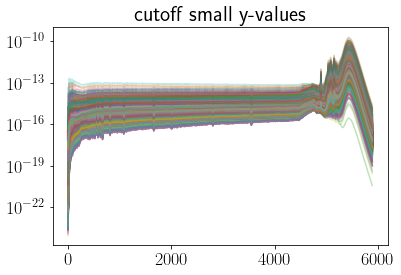

In [37]:
plt.plot(Y_loaded.T[100:,:], alpha = 0.3)
plt.yscale('log')
plt.title('cutoff small y-values')
plt.show()

In [38]:
## logging and clipping
# X_loaded = np.log10(X_loaded)
Y_log = np.log10(Y_loaded[:, 100:])

# ### rescaling 
# y_mean = np.mean(Y_log, axis=0)
# y_mult = np.max(Y_log - y_mean, axis=0)


y_mean = np.loadtxt('y_mean.txt')
y_mult = np.loadtxt('y_mult.txt')


y_train = (Y_log - y_mean)/y_mult

# ### rescaling 
# x_mean = np.mean(X_loaded, axis=0)
# x_mult = np.max(X_loaded - x_mean, axis=0)

x_mean = np.loadtxt('x_mean.txt')
x_mult = np.loadtxt('x_mult.txt')

x_train = (X_loaded - x_mean)/x_mult

## loading trained GP and PCA models

In [39]:
num_params = 3
num_bases = 10

with open('pcaModel.pickle', 'rb') as handle:
    pca_model = pickle.load(handle)

gp_model = GPy.models.GPRegression.load_model('gpfit_'+str(num_bases)+'_'+str(num_params) + '.zip')

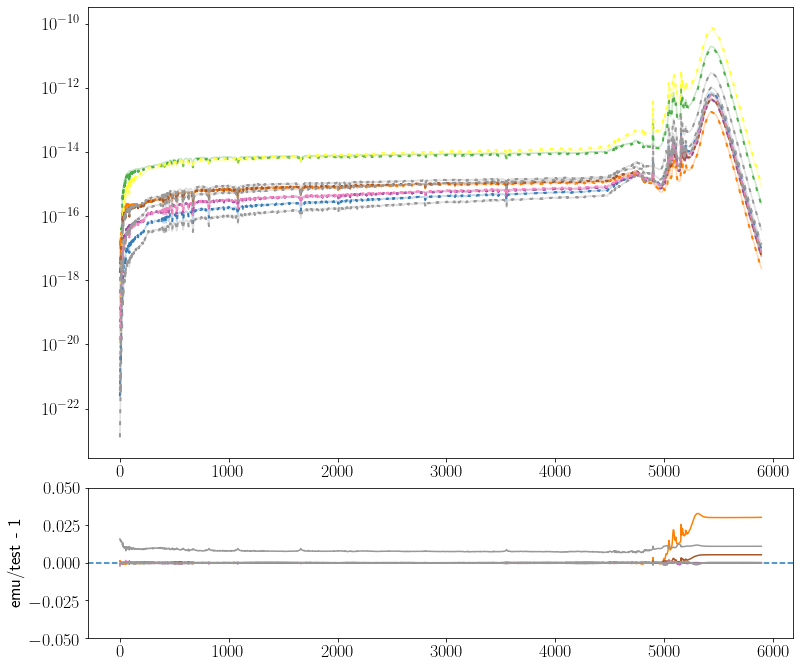

In [42]:
np.random.seed(12)

from matplotlib import gridspec
from itertools import cycle
import matplotlib.ticker as ticker

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))


gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# ax0.set_ylabel(r'$P(k)$',  fontsize = 18)

# ax1.set_xlabel(r'$k$',  fontsize = 18)
ax1.axhline(y=0, ls='dashed')


ax0.set_yscale('log', basey=10)
# ax0.set_xscale('log', basex=10)
# ax1.set_xscale('log', basex=10)

ax1.set_ylim(-0.05, 0.05)

# ax0.plot(y_train.T*y_mult + y_mean , 'k-', alpha = 0.01)
# ax0.plot(10**y_train.T, 'k-', alpha = 0.01)

ax1.set_ylabel(r'emu/test - 1',  fontsize = 18)


start, end = ax0.get_ylim()
# ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e1'))

color_id = 0
for i in range(10):
    color_id += 1
    rand_idx = (np.random.randint(100, 2000))
    rand_params = X_loaded[rand_idx]
    y_emu = emulator(pca_model, gp_model, rand_params)
    y_true = 10**((y_train[rand_idx]*y_mult)+y_mean)

    ax0.plot( y_emu, color=plt.cm.Set1(color_id), alpha = 0.3)
    ax0.plot( y_true, '--', color=plt.cm.Set1(color_id), lw = 2, dashes=(2, 4))
    ax1.plot( y_emu/y_true - 1, color=plt.cm.Set1(color_id))

    
plt.show()

In [45]:
%%timeit

y_emu = emulator(pca_model, gp_model, X_loaded[20])

5.48 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


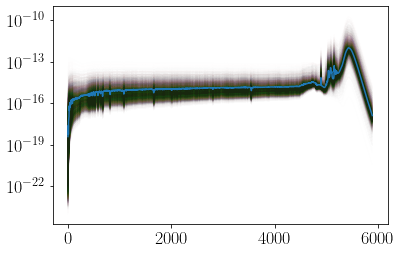

In [46]:
plt.figure(1223)
plt.plot(Y_loaded.T[100:,:], alpha = 0.002)
plt.plot(y_emu, alpha = 1.0)
plt.yscale('log')
# plt.title('cutoff small y-values')
plt.show()

# All you need for the emulation

In [48]:
x_mean = np.loadtxt('x_mean.txt')
x_mult = np.loadtxt('x_mult.txt')

y_mean = np.loadtxt('y_mean.txt')
y_mult = np.loadtxt('y_mult.txt')

num_params = 3
num_bases = 10

save_loc = "/Users/nramachandra/Desktop/Projects/AGNfinder/FSPS/"

with open('pcaModel.pickle', 'rb') as handle:
    pca_model = pickle.load(handle)

gp_model = GPy.models.GPRegression.load_model('gpfit_'+str(num_bases)+'_'+str(num_params) + '.zip')

y_emu = emulator(pca_model, gp_model, X_loaded[20])